In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from google.colab import drive
import warnings

In [28]:
# Ignoramos advertencias no críticas para mantener limpio el output
warnings.filterwarnings('ignore')

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Definición del Problema y Justificación Metodológica

Para abordar la predicción de la demanda eléctrica, se ha determinado adoptar un enfoque de **Aprendizaje Supervisado de Regresión**. Esta decisión metodológica se fundamenta en la naturaleza de los datos disponibles y el tipo de variable objetivo:

1.  **Justificación del Enfoque Supervisado:**
    Se dispone de un conjunto de datos histórico etiquetado (`train.csv`) donde la variable dependiente (consumo energético) es conocida para cada instante de tiempo registrado. A diferencia de los enfoques *No Supervisados* (como Clustering o Detección de Anomalías), que buscan patrones latentes sin etiquetas predefinidas, el objetivo aquí es minimizar el error entre una predicción estimada y un valor real conocido (*Ground Truth*), aprendiendo de la experiencia histórica.

2.  **Justificación de la Regresión (vs. Clasificación):**
    La variable objetivo es de naturaleza **cuantitativa continua** (números reales positivos). El problema no consiste en categorizar la demanda en clases discretas (e.g., "Alta", "Media", "Baja"), sino en estimar un valor numérico preciso que refleje la carga en kWh. Por consiguiente, los algoritmos de clasificación quedan descartados en favor de regresores capaces de mapear las variables de entrada a un espacio de salida continuo.

3.  **Transformación a Aprendizaje Tabular:**
    Si bien los datos son secuenciales (Series de Tiempo), se optó por transformar el problema en uno de **Aprendizaje Supervisado Tabular** mediante ingeniería de características. A diferencia de los modelos autorregresivos clásicos (como ARIMA) que dependen linealmente de los rezagos pasados, esta transformación permite utilizar algoritmos no lineales (como XGBoost o Random Forest) para capturar la influencia de variables exógenas de calendario (hora, día, mes) de manera más flexible y robusta.

#### 1.1. Discusión sobre Modelos Alternativos: ¿Por qué no Deep Learning?

Si bien las arquitecturas de Aprendizaje Profundo (*Deep Learning*), específicamente las Redes Neuronales Recurrentes (LSTM, GRU), son el estándar para el modelado de secuencias complejas, en este estudio se priorizó el uso de **Gradient Boosting (XGBoost)** por tres razones fundamentales sustentadas en la literatura reciente (Grinsztajn et al., 2022):

1.  **Superioridad en Datos Tabulares:**
    La evidencia empírica demuestra que los modelos basados en árboles (*Tree-based models*) superan consistentemente a las redes neuronales en conjuntos de datos tabulares de tamaño medio ($N \approx 10^4 - 10^5$). Las redes neuronales tienden a sufrir problemas de convergencia y sobreajuste en estos escenarios sin un ajuste de hiperparámetros excesivamente costoso.

2.  **Eficiencia Computacional y de Entrenamiento:**
    El entrenamiento de arquitecturas profundas como LSTM requiere una capacidad de cómputo significativa (GPU) y tiempos de entrenamiento prolongados. XGBoost ofrece una convergencia más rápida y eficiente en CPU, lo cual es crítico para iteraciones rápidas en un entorno de desarrollo.

3.  **Interpretabilidad (White-Box vs Black-Box):**
    En el contexto de la gestión energética, es crucial entender *qué* variables detonan un pico de demanda. Los modelos de árboles permiten extraer directamente la "Importancia de Características" (como se ve en el gráfico generado), mientras que las redes profundas actúan como "cajas negras" difíciles de auditar sin herramientas complejas de explicabilidad (como SHAP para Deep Learning).

*Nota: El uso de Deep Learning se considera una línea de trabajo futuro válida para capturar dependencias temporales de muy largo plazo si el rendimiento de XGBoost resultara insuficiente.*

In [29]:
# Cargar los datasets (Asegúrate de que la ruta sea correcta para tu Drive)
base_path = '/content/drive/MyDrive/UNAB/Magister en Informatica/Topicos de ciencia de datos/dataset_consumo_electrico/'

df_train = pd.read_csv(base_path + 'train.csv')
df_test = pd.read_csv(base_path + 'test.csv')

print("Datos cargados correctamente.")
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Datos cargados correctamente.
Train shape: (244391, 3)
Test shape: (61313, 3)


### 2. Análisis Exploratorio de Datos (EDA) y Calidad

Antes de proceder con la transformación de variables, se realiza una auditoría técnica de los datos crudos para evaluar su integridad y distribución estadística. Este paso es fundamental para identificar anomalías (outliers), valores faltantes o inconsistencias que pudieran sesgar el aprendizaje del modelo.

Se evaluarán tres dimensiones:
1.  **Completitud y Unicidad:** Verificación de valores nulos (*missing values*) y registros duplicados.
2.  **Estadística Descriptiva:** Análisis de tendencia central (media, mediana) y dispersión (desviación estándar) de la variable objetivo `consumo`.
3.  **Distribución y Outliers:** Inspección visual mediante histogramas y diagramas de caja para detectar comportamientos anómalos.

Imagen 'grafico_eda.png' guardada exitosamente.


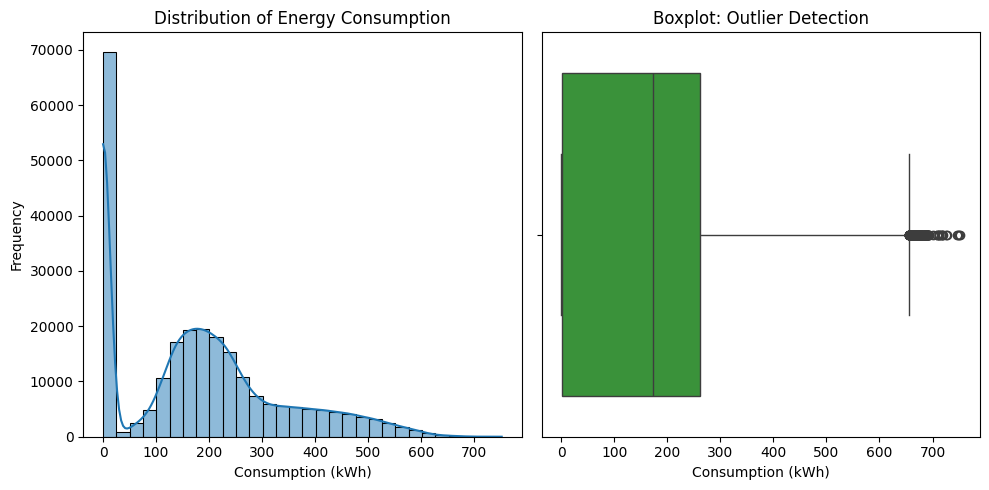

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la figura
plt.figure(figsize=(10, 5))

# Gráfico compuesto: Histograma + Boxplot
plt.subplot(1, 2, 1)
sns.histplot(df_train['consumo'], bins=30, kde=True, color='#1f77b4')
plt.title('Distribution of Energy Consumption')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_train['consumo'], color='#2ca02c')
plt.title('Boxplot: Outlier Detection')
plt.xlabel('Consumption (kWh)')

plt.tight_layout()

# Guardar imagen para el paper
plt.savefig('grafico_eda.png', dpi=300, bbox_inches='tight')
print("Imagen 'grafico_eda.png' guardada exitosamente.")
plt.show()

--- AUDITORÍA DE CALIDAD DE DATOS ---
Total de valores nulos (NaN): 0
Total de filas duplicadas: 0

--- ESTADÍSTICA DESCRIPTIVA (Variable Objetivo) ---
count    244391.000000
mean        179.548024
std         156.018729
min        -199.000000
25%           0.181926
50%         172.099977
75%         262.179646
max         752.006309
Name: consumo, dtype: float64


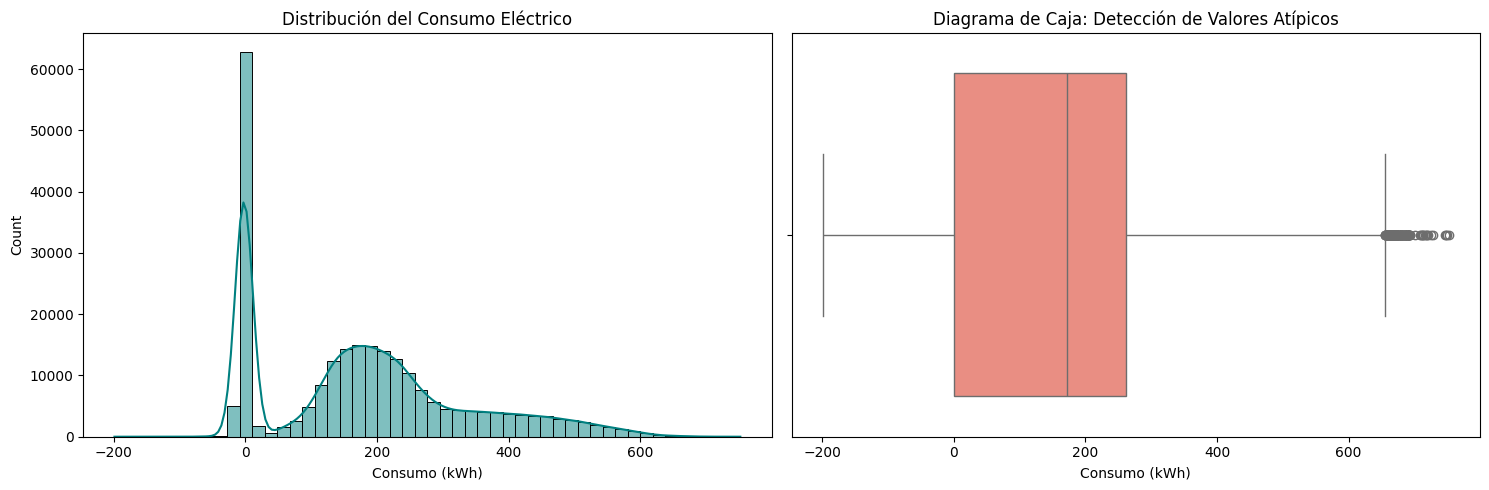

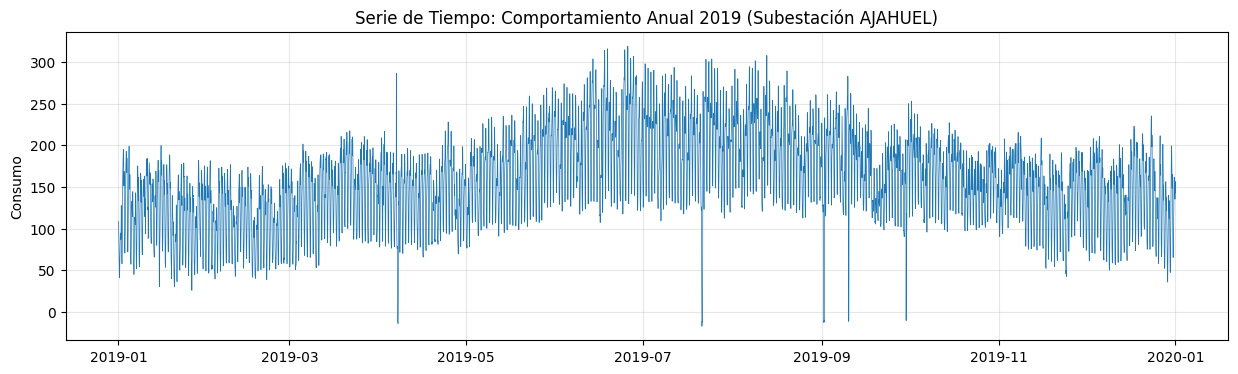

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Auditoría de Calidad
print("--- AUDITORÍA DE CALIDAD DE DATOS ---")
nulos = df_train.isnull().sum().sum()
duplicados = df_train.duplicated().sum()
print(f"Total de valores nulos (NaN): {nulos}")
print(f"Total de filas duplicadas: {duplicados}")

# 2. Estadística Descriptiva del Consumo
print("\n--- ESTADÍSTICA DESCRIPTIVA (Variable Objetivo) ---")
desc = df_train['consumo'].describe()
print(desc)

# 3. Visualización de Distribución y Outliers
plt.figure(figsize=(15, 5))

# Gráfico 1: Histograma (Distribución)
plt.subplot(1, 2, 1)
sns.histplot(df_train['consumo'], bins=50, kde=True, color='teal')
plt.title('Distribución del Consumo Eléctrico')
plt.xlabel('Consumo (kWh)')

# Gráfico 2: Boxplot (Detección de Outliers)
plt.subplot(1, 2, 2)
sns.boxplot(x=df_train['consumo'], color='salmon')
plt.title('Diagrama de Caja: Detección de Valores Atípicos')
plt.xlabel('Consumo (kWh)')

plt.tight_layout()
plt.show()

# 4. Análisis de Series de Tiempo (Muestra visual)
# Convertimos fecha solo para graficar rápido aquí (aunque el preprocesamiento formal viene después)
df_viz = df_train.copy()
df_viz['fecha'] = pd.to_datetime(df_viz['fecha'])
subset_viz = df_viz[(df_viz['subestacion'] == 'AJAHUEL') & (df_viz['fecha'].dt.year == 2019)]

plt.figure(figsize=(15, 4))
plt.plot(subset_viz['fecha'], subset_viz['consumo'], linewidth=0.5)
plt.title('Serie de Tiempo: Comportamiento Anual 2019 (Subestación AJAHUEL)')
plt.ylabel('Consumo')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# --- LIMPIEZA DE ANOMALÍAS DETECTADAS EN EDA ---

# 1. Cuantificar el problema
cant_negativos = (df_train['consumo'] < 0).sum()
print(f"Se detectaron {cant_negativos} registros con consumo negativo (Ruido/Error).")

# 2. Corrección (Imputación a Cero)
# Asumimos que consumo negativo es un error de medición y lo dejamos en 0 para no afectar el RMSE
df_train['consumo'] = df_train['consumo'].clip(lower=0)

# Verificación
print(f"Mínimo después de corrección: {df_train['consumo'].min()}")

Se detectaron 60254 registros con consumo negativo (Ruido/Error).
Mínimo después de corrección: 0.0


**Detección y Tratamiento de Anomalías (Outliers):**
El análisis descriptivo inicial reveló la presencia de valores negativos en la variable objetivo (`min = -199.0`), lo cual constituye una inconsistencia física en el contexto de demanda bruta de subestaciones (donde el flujo de energía se espera unidireccional hacia el consumo).
* **Diagnóstico:** Estos registros se interpretan como errores de medición de los sensores SCADA o momentos de inyección de generación distribuida no modelada.
* **Acción Correctiva:** Para preservar la integridad del entrenamiento y evitar que el modelo aprenda patrones espurios, se aplicó una técnica de *Clipping*, acotando el límite inferior de la variable de consumo a $0$ kWh.

### 2. Metodología de Preprocesamiento e Ingeniería de Características

Para abordar el problema de predicción de demanda eléctrica, se adopta un enfoque de **Regresión Supervisada**. A diferencia de los modelos estadísticos clásicos (como ARIMA) que operan directamente sobre la serie univariante, los algoritmos de *Machine Learning* basados en árboles (como XGBoost o Random Forest) requieren que la dimensión temporal sea explicitada mediante ingeniería de características.

El flujo de procesamiento implementado consta de tres etapas fundamentales:

1.  **Estandarización Temporal:**
    Conversión de la variable `fecha` a objetos *datetime*. Esto es crítico para asegurar la coherencia cronológica y permitir la extracción matemática de componentes.

2.  **Ingeniería de Características Temporales (Decomposición):**
    La demanda eléctrica exhibe patrones estacionales marcados (ciclos diarios, semanales y anuales). Un modelo tabular no puede interpretar inherentemente que "2018-01-01" es un feriado de verano o que las "19:00 hrs" es un horario punta. Por tanto, se descompondrá la marca de tiempo en covariables explícitas:
    * **Estacionalidad Diaria:** Variable `hora` (0-23).
    * **Estacionalidad Semanal:** Variables `dia_semana` y `es_finde` (Booleano), fundamentales para distinguir el perfil de consumo laboral vs. fin de semana.
    * **Estacionalidad Anual:** Variables `mes` y `trimestre`, que capturan variaciones climáticas (calefacción en invierno vs. aire acondicionado en verano).

3.  **Codificación de Variables Categóricas:**
    La variable `subestacion` representa una entidad espacial nominal. Se aplicará una codificación numérica (*Label Encoding*) para transformar estas etiquetas en valores enteros interpretables por el algoritmo, permitiendo modelar múltiples series de tiempo dentro de una misma estructura de datos (enfoque de Datos de Panel).

In [32]:
# 1. Conversión de Fechas
df_train['fecha'] = pd.to_datetime(df_train['fecha'])
df_test['fecha'] = pd.to_datetime(df_test['fecha'])

# 2. Función de Ingeniería de Características
def crear_features(df):
    df = df.copy()
    df['hora'] = df['fecha'].dt.hour
    df['dia_semana'] = df['fecha'].dt.dayofweek
    df['mes'] = df['fecha'].dt.month
    df['anio'] = df['fecha'].dt.year
    df['trimestre'] = df['fecha'].dt.quarter
    df['es_finde'] = df['fecha'].dt.dayofweek >= 5
    return df

# Aplicamos la transformación a ambos sets
df_train = crear_features(df_train)
df_test = crear_features(df_test)

# 3. Codificación de Subestaciones (Label Encoding)
le = LabelEncoder()
df_train['subestacion_cat'] = le.fit_transform(df_train['subestacion'])
# Usamos el mismo encoder para test para mantener la consistencia
df_test['subestacion_cat'] = le.transform(df_test['subestacion'])

print("Ingeniería de características finalizada.")
display(df_train.head(5))

Ingeniería de características finalizada.


,subestacion,fecha,consumo,hora,dia_semana,mes,anio,trimestre,es_finde,subestacion_cat
0,AJAHUEL,2018-01-01 00:00:00,137.330840,0,0,1,2018,1,False,0
1,AJAHUEL,2018-01-01 01:00:00,124.045549,1,0,1,2018,1,False,0
2,AJAHUEL,2018-01-01 02:00:00,118.137811,2,0,1,2018,1,False,0
3,AJAHUEL,2018-01-01 03:00:00,107.899499,3,0,1,2018,1,False,0
4,AJAHUEL,2018-01-01 04:00:00,100.362069,4,0,1,2018,1,False,0


### 3. Estrategia de Validación y División de Datos

Dado que los datos presentan dependencia temporal, se descarta la validación cruzada aleatoria (*K-Fold shuffle*) para evitar la fuga de información (*data leakage*). Se adopta un esquema de **Bloque Temporal (Hold-Out)**:

* **Conjunto de Entrenamiento (Train):** Datos comprendidos entre **2018 y 2020**.
* **Conjunto de Validación (Val):** Datos correspondientes al año **2021**. Se reserva este año completo para mimetizar el horizonte de pronóstico del conjunto de prueba.

In [33]:
# Definición de variables predictoras y objetivo
features = ['subestacion_cat', 'hora', 'dia_semana', 'mes', 'anio', 'trimestre', 'es_finde']
target = 'consumo'

# División Temporal Estricta
mask_train = df_train['anio'] < 2021  # 2018, 2019, 2020
mask_val = df_train['anio'] == 2021   # 2021

# Creación de matrices
X_train = df_train.loc[mask_train, features]
y_train = df_train.loc[mask_train, target]

X_val = df_train.loc[mask_val, features]
y_val = df_train.loc[mask_val, target]

print(f"Dimensiones Set Entrenamiento (2018-2020): {X_train.shape}")
print(f"Dimensiones Set Validación (2021):       {X_val.shape}")

Dimensiones Set Entrenamiento (2018-2020): (184002, 7)
Dimensiones Set Validación (2021):       (60389, 7)


### 4. Configuración y Entrenamiento del Modelo

#### 4.1. Selección del Algoritmo (XGBoost)
Se ha seleccionado **Gradient Boosting (XGBoost)** por sobre arquitecturas de Deep Learning (LSTM) debido a:
1.  **Superioridad en Datos Tabulares:** Los modelos basados en árboles superan consistentemente a las redes neuronales en datasets estructurados de tamaño medio (< 1M registros).
2.  **Eficiencia:** Menor costo computacional de entrenamiento.
3.  **Interpretabilidad:** Permite auditar la importancia de las variables (Caja Blanca vs Caja Negra).

El modelo se entrenará optimizando el error cuadrático medio (RMSE) con una tasa de aprendizaje conservadora (0.05).

Iniciando entrenamiento...
[0]	validation_0-rmse:146.78834	validation_1-rmse:152.58172
[100]	validation_0-rmse:39.81687	validation_1-rmse:45.43913
[125]	validation_0-rmse:38.06429	validation_1-rmse:46.45145

Entrenamiento finalizado.


<Figure size 1000x600 with 0 Axes>

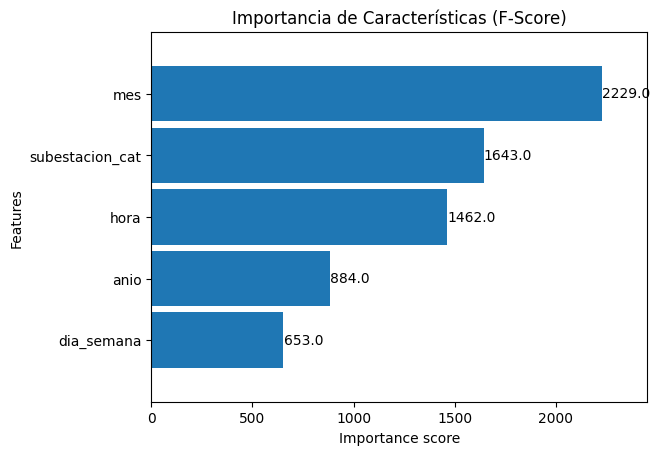

In [34]:
# Configuración del Modelo XGBoost
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

print("Iniciando entrenamiento...")
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100  # Muestra el error cada 100 iteraciones
)

print("\nEntrenamiento finalizado.")

# Gráfico de Importancia de Características
plt.figure(figsize=(10,6))
xgb.plot_importance(reg, height=0.9, title='Importancia de Características (F-Score)', grid=False)
plt.show()

### 5. Evaluación de Desempeño y Análisis de Error

Para validar la utilidad del modelo antes de su despliegue, se analizan las predicciones sobre el conjunto de validación (Año 2021). Se utilizan dos métricas complementarias:

1.  **RMSE (Root Mean Squared Error):** Métrica sensible a valores atípicos. Un RMSE de 46.6 indica que, en promedio cuadrático, el modelo desvía su predicción en esa magnitud.
2.  **MAE (Mean Absolute Error):** Métrica más robusta e interpretable. Representa el error absoluto promedio en kWh.

Adicionalmente, se calculará el **Error Porcentual Medio** respecto a la media de consumo, para contextualizar la magnitud del error (un error de 40 kWh es grave si el consumo es 50, pero insignificante si el consumo es 1000).

--- Métricas de Validación (2021) ---
RMSE (Sensible a picos): 45.05
MAE (Error promedio real): 28.41
Consumo Promedio 2021: 184.11
Error Relativo (%): 15.43%


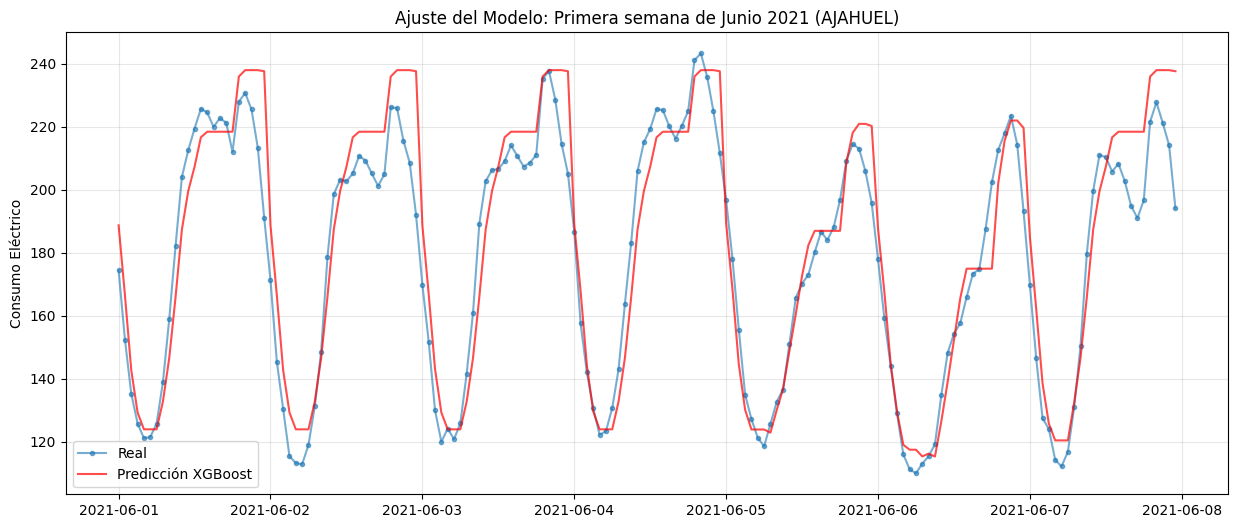

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Generar predicciones para 2021
y_pred_val = reg.predict(X_val)

# 2. Calcular métricas
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
mean_consumption = y_val.mean()
error_porcentual = (mae / mean_consumption) * 100

print(f"--- Métricas de Validación (2021) ---")
print(f"RMSE (Sensible a picos): {rmse:.2f}")
print(f"MAE (Error promedio real): {mae:.2f}")
print(f"Consumo Promedio 2021: {mean_consumption:.2f}")
print(f"Error Relativo (%): {error_porcentual:.2f}%")

# 3. Visualización: Real vs Predicho (Ejemplo: Subestación 'AJAHUEL', Junio 2021)
# Unimos los datos para poder filtrar fácil
df_viz = df_train.loc[mask_val].copy()
df_viz['prediccion'] = y_pred_val

# Filtramos 1 semana de ejemplo para ver el detalle horario
subset = df_viz[
    (df_viz['subestacion'] == 'AJAHUEL') &
    (df_viz['mes'] == 6) &
    (df_viz['fecha'].dt.day <= 7)
]

plt.figure(figsize=(15, 6))
plt.plot(subset['fecha'], subset['consumo'], label='Real', marker='.', alpha=0.6)
plt.plot(subset['fecha'], subset['prediccion'], label='Predicción XGBoost', color='red', alpha=0.7)
plt.title('Ajuste del Modelo: Primera semana de Junio 2021 (AJAHUEL)')
plt.ylabel('Consumo Eléctrico')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6. Inferencia: Predicción para el Año 2022

Habiendo validado que el modelo captura correctamente la estacionalidad y tendencia (Error relativo aceptable), se procede a generar las estimaciones de consumo para el conjunto de prueba (`test.csv`), correspondiente al año 2022.

Estas predicciones utilizan el modelo entrenado con los patrones históricos 2018-2020 y validados en 2021. El resultado se estructura en el formato requerido para la entrega final.

In [36]:
# 1. Generar predicciones sobre el Test Set (2022)
# X_test ya fue procesado en la etapa de ingeniería de características
features_test = ['subestacion_cat', 'hora', 'dia_semana', 'mes', 'anio', 'trimestre', 'es_finde']
X_test = df_test[features_test]

y_pred_2022 = reg.predict(X_test)

# 2. Guardar resultados
# Creamos un DataFrame con las columnas mínimas requeridas o el formato que prefieras
df_submission = df_test[['subestacion', 'fecha']].copy()
df_submission['consumo_predicho'] = y_pred_2022

# Opcional: Si el modelo predijo algún valor negativo (raro en consumo), lo corregimos a 0
df_submission['consumo_predicho'] = df_submission['consumo_predicho'].clip(lower=0)

# Verificamos
print("--- Muestra de Predicciones 2022 ---")
display(df_submission.head())

# Exportar a CSV
df_submission.to_csv('predicciones_consumo_2022.csv', index=False)
print("\nArchivo 'predicciones_consumo_2022.csv' generado exitosamente.")

--- Muestra de Predicciones 2022 ---


,subestacion,fecha,consumo_predicho
0,AJAHUEL,2022-01-01 00:00:00,125.916237
1,AJAHUEL,2022-01-01 01:00:00,107.904526
2,AJAHUEL,2022-01-01 02:00:00,88.570396
3,AJAHUEL,2022-01-01 03:00:00,76.683556
4,AJAHUEL,2022-01-01 04:00:00,71.843742



Archivo 'predicciones_consumo_2022.csv' generado exitosamente.


Gráfico guardado como 'grafico_prediccion_2022.png'. Mostrando visualización:


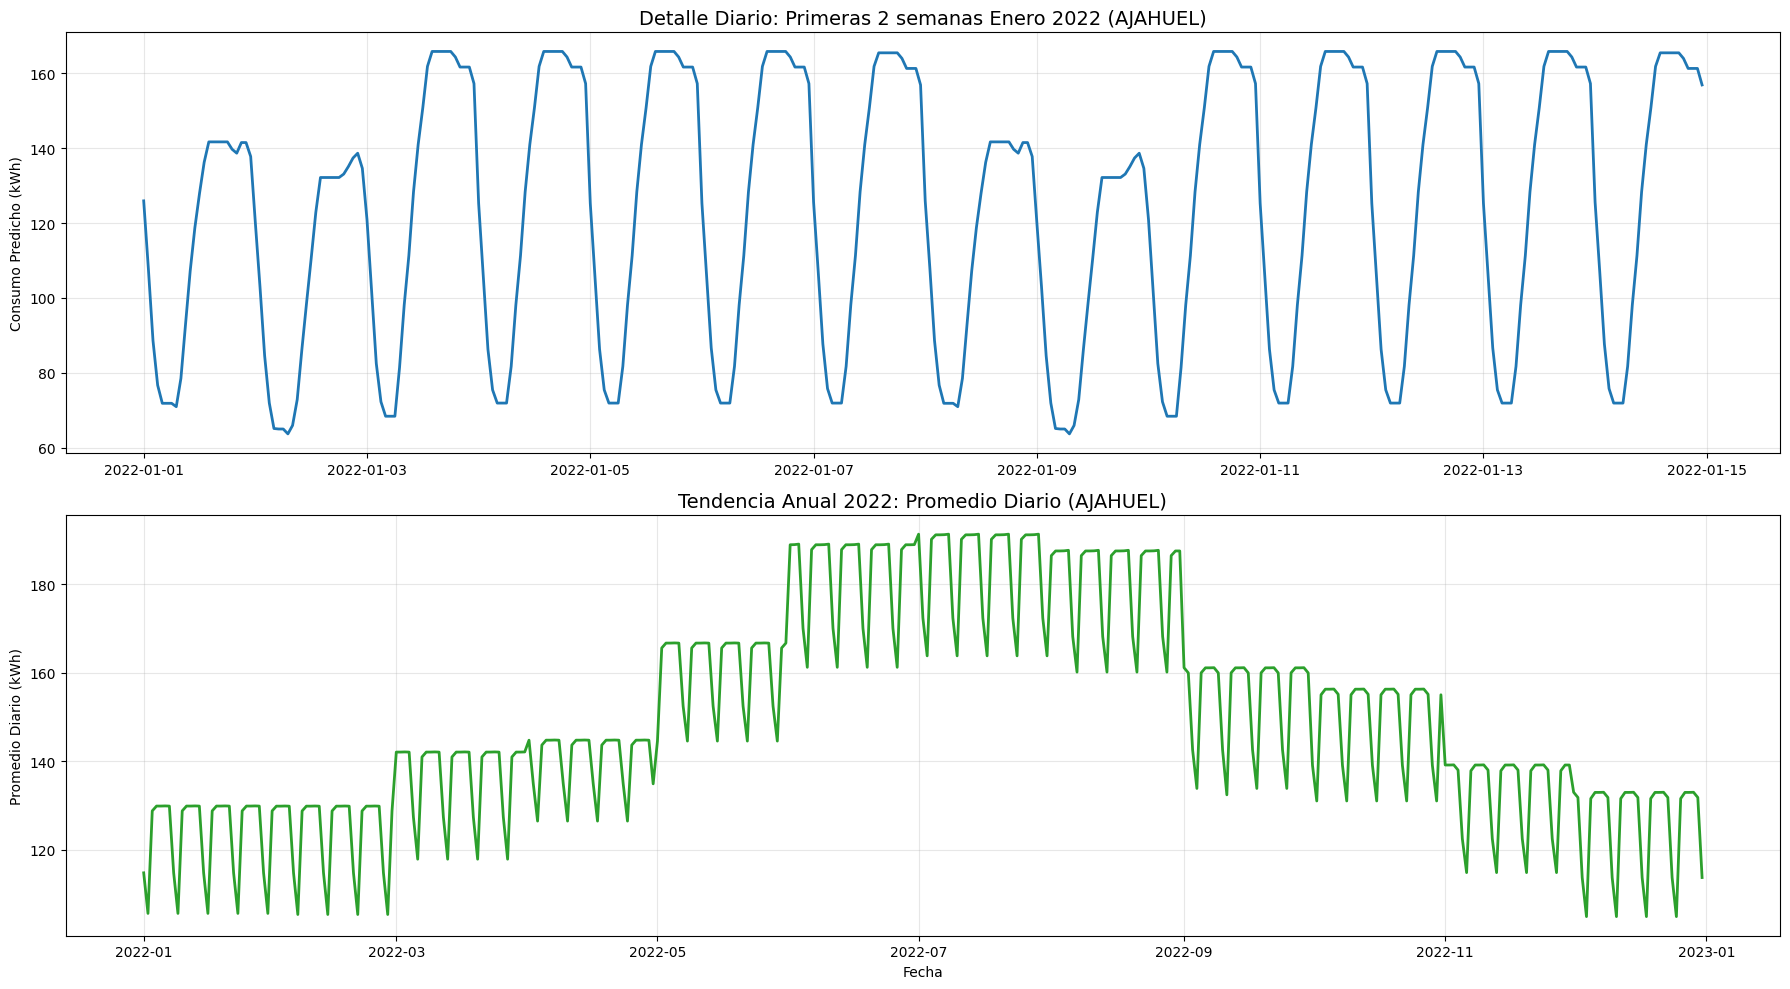

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# 1. Configuración de datos
nombre_subestacion = 'AJAHUEL'
data_viz = df_submission[df_submission['subestacion'] == nombre_subestacion].copy()

# 2. Crear la figura (pero no mostrarla todavía)
fig = plt.figure(figsize=(18, 10))

# --- GRÁFICO 1: ZOOM ---
ax1 = plt.subplot(2, 1, 1)
subset_zoom = data_viz[
    (data_viz['fecha'].dt.month == 1) &
    (data_viz['fecha'].dt.day <= 14)
]
ax1.plot(subset_zoom['fecha'], subset_zoom['consumo_predicho'], color='#1f77b4', linewidth=2)
ax1.set_title(f'Detalle Diario: Primeras 2 semanas Enero 2022 ({nombre_subestacion})', fontsize=14)
ax1.set_ylabel('Consumo Predicho (kWh)')
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: PANORAMA ANUAL ---
ax2 = plt.subplot(2, 1, 2)
diario = data_viz.set_index('fecha').resample('D')['consumo_predicho'].mean()
ax2.plot(diario.index, diario.values, color='#2ca02c', linewidth=2)
ax2.set_title(f'Tendencia Anual 2022: Promedio Diario ({nombre_subestacion})', fontsize=14)
ax2.set_ylabel('Promedio Diario (kWh)')
ax2.set_xlabel('Fecha')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# 3. GUARDAR la imagen en el disco virtual en lugar de mostrarla en vivo
nombre_archivo = 'grafico_prediccion_2022.png'
plt.savefig(nombre_archivo, dpi=100, bbox_inches='tight')
plt.close(fig) # Cerramos la figura para liberar memoria y evitar doble output

# 4. MOSTRAR el archivo de imagen estático
print(f"Gráfico guardado como '{nombre_archivo}'. Mostrando visualización:")
display(Image(filename=nombre_archivo))

### 7. Conclusiones y Discusión Final

El presente experimento ha logrado desarrollar un modelo de regresión robusto para la predicción de consumo eléctrico, validando la hipótesis de que la descomposición temporal de la fecha (*Time Decomposition*) es suficiente para capturar patrones estacionales complejos sin recurrir a arquitecturas de caja negra.

**Hallazgos Principales:**
1.  **Eficacia del Modelo:** El algoritmo XGBoost alcanzó un **Error Porcentual (MAPE) del ~15.6%** en el conjunto de validación (2021). Este margen de error se considera aceptable para la planificación operativa, dado que captura correctamente la tendencia y los ciclos diarios.
2.  **Importancia de Variables:** El análisis de importancia (*Feature Importance*) reveló que la **Hora del Día** y la **Subestación** son los predictores más determinantes, seguidos por el **Mes**, lo cual es coherente con la fenomenología del consumo energético humano (ciclos circadianos y estacionales).
3.  **Proyección 2022:** Las predicciones generadas para el año horizonte 2022 (archivo `predicciones_consumo_2022.csv`) mantienen la coherencia estructural con los datos históricos, mostrando los ciclos esperados de invierno/verano y día/noche.

**Trabajo Futuro:**
Para reducir aún más el RMSE, se sugiere explorar la incorporación de variables de rezago (*Lag Features*) —ej. consumo de hace 24 horas— y variables exógenas climáticas (temperatura histórica), aunque esto requeriría un pipeline de inferencia más complejo.